In [314]:
pip install xarray rioxarray

# Interpolation to Predictor Grid Coordinates

In [315]:
import xarray as xr
import numpy as np
import rioxarray
from scipy.interpolate import interpn, griddata


pred_ds = xr.open_dataset('/content/CM_CURIE_POINT_DEPTH_KM_Li2017.5m_EASE9262.68m.nc')
tar_ds = rioxarray.open_rasterio('/content/EMAG2_V3_20170530_UpCont.tif')

pred_lat = np.asarray(pred_ds.lat.values)
pred_lon = np.asarray(pred_ds.lon.values)
pred_data = np.asarray(pred_ds.z.values)

#meshgrid used for interpolation
pred_xx, pred_yy = np.meshgrid(pred_lon, pred_lat)

tar_ds[0].shape

(5399, 10800)

Need to change the fill value of this data to nan format

In [316]:
tar_ds

<xarray.DataArray (band: 1, y: 5399, x: 10800)>
[58309200 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.0 0.03333 0.06667 0.1 ... 359.9 359.9 359.9 360.0
  * y            (y) float64 89.97 89.93 89.9 89.87 ... -89.9 -89.93 -89.97
    spatial_ref  int64 0
Attributes:
    _FillValue:    -3.4028235e+38
    scale_factor:  1.0
    add_offset:    0.0

## EMAG Preparation
Correcting longitude range
* (x = lon) is (0, 360) instead of (-180, 180)

Adjusting data to new lon
* Sort data after changing lon values




In [317]:
#converting longitude range
tar_ds.coords['x'] = (tar_ds.coords['x'] + 180) % 360 - 180  #convert coordinates to new range
tar_ds = tar_ds.sortby(tar_ds.x) #sort the values based on new range

#adjusting latitude orientation
tar_ds = tar_ds.sortby('y', ascending=True)

Initialize variables for interpolation

In [319]:
#select for single band of data
tar_ds = tar_ds[0]

tar_lat = tar_ds.y.values
tar_lon = tar_ds.x.values

tar_data = tar_ds.values

#meshgrid for interpolation (not needed)
#tar_xx, tar_yy = np.meshgrid(tar_lon, tar_lat)

Changing fill value
* (-3.4028235e+38) to nan

In [318]:
#convert the fill value to numpy nan
fill_value = -3.4028235e+38

#replace the fill value with nan


## Interpolation Method

* points = tuple of arrays, representing all data to use for interpolation
* coords = all coordinates to interpolate to in new grid

In [320]:
#define the points that correlate to existing data
points = (tar_lat, tar_lon)
coords = (pred_yy, pred_xx)

We interpolate the data to the new grid
* reshape converts interp_tar back to a 2-D ndarray

In [321]:
interp_tar = interpn(points, tar_data, coords)
interp_tar = interp_tar.reshape(pred_xx.shape)

## Validation
accuracy of interpolation method

Shape

In [322]:
print(pred_data.shape == interp_tar.shape)

True


Ranges

In [323]:
print(np.nanmin(tar_data))
print(np.nanmin(interp_tar))
print(np.nanmax(tar_data))
print(np.nanmax(interp_tar))

-3.4028235e+38
-3.4028234663852897e+38
8632.614
8453.781865111543


Statistics

In [338]:
#stat tests here to validate data consistency
print(np.nanmean(interp_tar))
print(np.nanmedian(interp_tar))
print(np.nanstd(interp_tar))

-1.3587250429558943e+37
-3.741377775566935
6.612776535867315e+37


numpy.ndarray

Plots


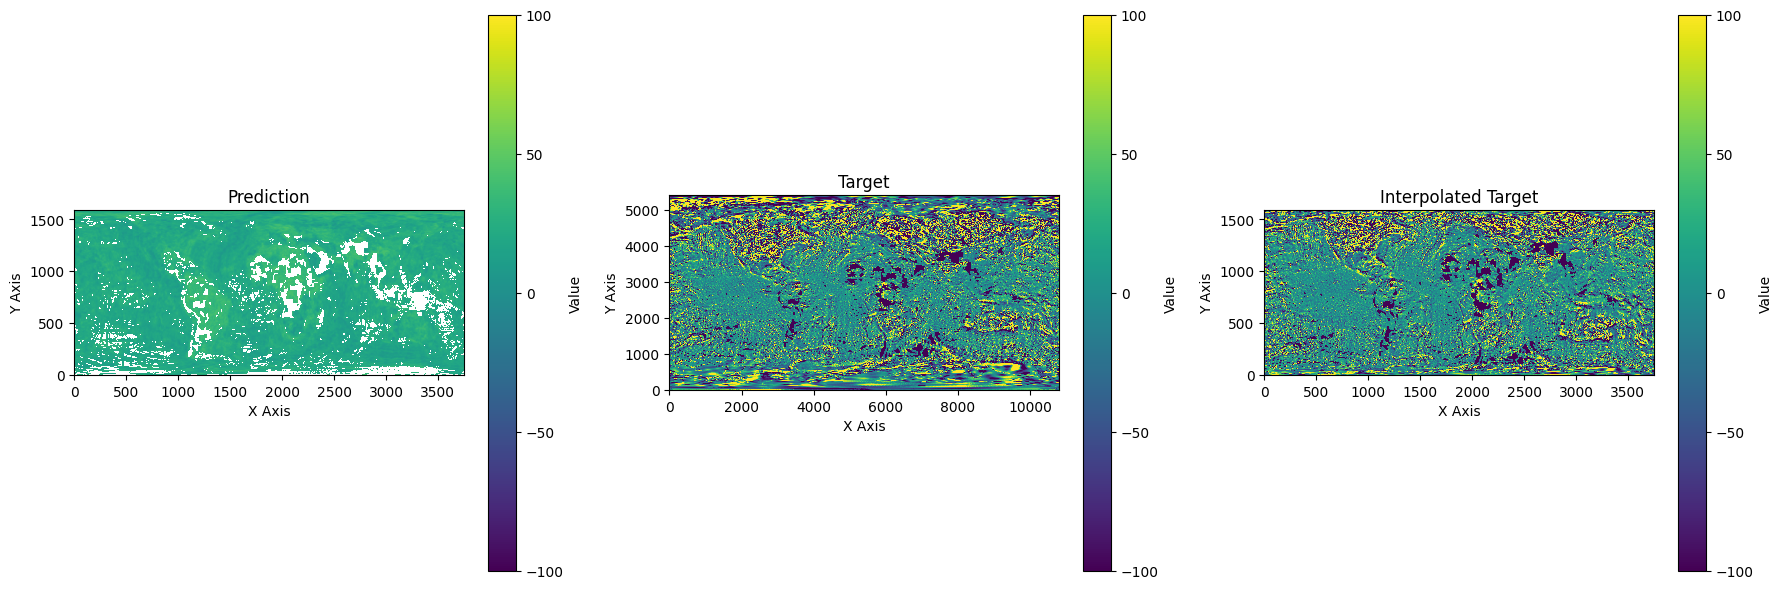

In [335]:
import numpy as np
import matplotlib.pyplot as plt

# Define color bar limits
vmin = -100  # Minimum value for color bar
vmax = 100  # Maximum value for color bar

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure with 1 row and 3 columns of subplots

# Plotting the prediction data
im1 = axs[0].imshow(pred_data, cmap='viridis', interpolation='nearest', origin='lower', vmin=vmin, vmax=vmax)
axs[0].set_title('Prediction')
fig.colorbar(im1, ax=axs[0], label='Value', ticks=np.linspace(vmin, vmax, num=5))

# Plotting the target data
im2 = axs[1].imshow(tar_data, cmap='viridis', interpolation='nearest', origin='lower', vmin=vmin, vmax=vmax)
axs[1].set_title('Target')
fig.colorbar(im2, ax=axs[1], label='Value', ticks=np.linspace(vmin, vmax, num=5))

# Plotting the interpolated target data
im3 = axs[2].imshow(interp_tar, cmap='viridis', interpolation='nearest', origin='lower', vmin=vmin, vmax=vmax)
axs[2].set_title('Interpolated Target')
fig.colorbar(im3, ax=axs[2], label='Value', ticks=np.linspace(vmin, vmax, num=5))

# Common labels
for ax in axs:
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')

plt.tight_layout()
plt.show()


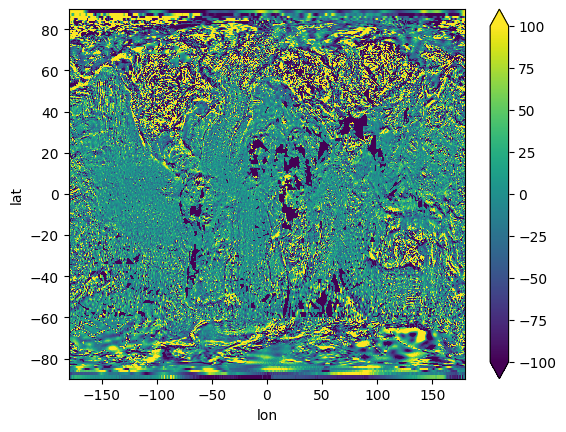

In [339]:
data_array = xr.DataArray(interp_tar, dims=['lat','lon'], coords= {'lat': pred_lat, 'lon': pred_lon})
data_array.plot(vmin=-100, vmax=100)
data_array.to_netcdf('interpolated_emag.nc')